# DESeq2 DE Analysis Pipeline

> https://zhuanlan.zhihu.com/p/375756362

- 依赖包:
   - DESeq2
   - RColorBrewer
   - gplots
   - pheatmap
   - ggplot2
- DESeq2对于输入数据的要求
   - 输入数据为整数构成的矩阵
   - 此矩阵必须是没有经过标准化(归一化/Normalize) 
- DESeq2进行差异表达分析
   - 构建dds矩阵
       ```
       dds <- DESeqDataSetFromMatrix(
                   countData = raw_counts, 
                   colData = column_info, 
                   design= ~ batch + condition) 
       #~在R里面用于构建公式对象，~左边为因变量，右边为自变量。
       ```

   - 标准化/归一化
       ```
       dds <- DESeq(dds) 
       #标准化
       ```
   - 差异分析
       ```
       res <- results(dds, contrast=c("condition","treated","control")) 
       #差异分析结果
       ```

## load tables

1. 读取样本信息（sample.txt）
2. 读取featureCounts产生的各个bam文件的counts信息
3. 检查raw_counts中的所有记录(row)的个数，这里代表count到的gene的个数, geneid被指定为row.names了所以不计在内

### 读取/构建样本信息

In [43]:
column_info <- read.table("sample.csv", header=TRUE, sep=',')
column_info

sample,condition,type
<chr>,<chr>,<chr>
LI-rep1,LI,treat
LI-rep2,LI,treat
mLN-rep1,mLN,treat
mLN-rep2,mLN,treat
pLN-rep1,pLN,treat
pLN-rep2,pLN,treat
SI-rep1,SI,treat
SI-rep2,SI,treat
spleen-rep1,spleen,treat


In [53]:
column_info$condition = factor(column_info$condition)
column_info$type = factor(column_info$type)
column_info

sample,condition,type
<chr>,<fct>,<fct>
LI-rep1,LI,treat
LI-rep2,LI,treat
mLN-rep1,mLN,treat
mLN-rep2,mLN,treat
pLN-rep1,pLN,treat
pLN-rep2,pLN,treat
SI-rep1,SI,treat
SI-rep2,SI,treat
spleen-rep1,spleen,treat


### 读取原始表达矩阵

In [54]:
raw_counts <- read.table(
    "../featureCounts/all_feature_fix_feed_to_deseq2.csv",
    header=TRUE,
    sep=',',
    row.names=1
)
# raw_counts <- raw_counts[,c(1,2,3,7,8,9)]
head(raw_counts, 5)

,LI.rep1,LI.rep2,mLN.rep1,mLN.rep2,pLN.rep1,pLN.rep2,SI.rep1,SI.rep2,spleen.rep1,spleen.rep2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Xkr4,32,40,31,33,18,17,24,26,0,29
Rp1,90,141,124,89,56,60,142,117,0,100
Sox17,5,9,3,2,1,3,2,2,0,4
Mrpl15,39,40,56,36,33,53,28,44,0,39
Lypla1,38,269,13,14,10,8,10,15,0,10


In [55]:
dim(raw_counts)

[1] 26214    10

In [4]:
# 看一下column_info 中的样本名称、处理条件
column_info

sample,condition,type
<chr>,<chr>,<chr>
LI-rep1,LI,treat
LI-rep2,LI,treat
mLN-rep1,mLN,treat
mLN-rep2,mLN,treat
pLN-rep1,pLN,treat
pLN-rep2,pLN,treat
SI-rep1,SI,treat
SI-rep2,SI,treat
spleen-rep1,spleen,treat


In [56]:
# 看一下raw_counts
# geneid为index，样本信息的counts数为columns
head(raw_counts)

,LI.rep1,LI.rep2,mLN.rep1,mLN.rep2,pLN.rep1,pLN.rep2,SI.rep1,SI.rep2,spleen.rep1,spleen.rep2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Xkr4,32,40,31,33,18,17,24,26,0,29
Rp1,90,141,124,89,56,60,142,117,0,100
Sox17,5,9,3,2,1,3,2,2,0,4
Mrpl15,39,40,56,36,33,53,28,44,0,39
Lypla1,38,269,13,14,10,8,10,15,0,10
Tcea1,23,457,25,20,16,79,12,17,0,24


4. 过滤掉行的和为0，也就是没有bam文件中count到reads的genes

In [57]:
### filt genes that don't express in all sample -------------------------------------------->
# 在step3是否进行了过滤？（RPKM >= 1）
raw_counts <- raw_counts[rowSums(raw_counts)>1,]
dim(raw_counts)

[1] 24974    10

### 过滤原始表达矩阵 

5. rownames函数调用矩阵的row.names
6. 调用stringr package中的str_split函数，去除geneid中的gene名的.以及后面的内容
7. 使用duplicated函数去掉重复的gn id   

In [58]:
### remove version in ensembl id ----------------------------------------------------------->
gn <- stringr::str_split(rownames(raw_counts),"\\.",simplify = T)[,1]
# gene_id如果已经是name，name这个也做不做无所谓↑
# remove duplicate
raw_counts <- raw_counts[!duplicated(gn),]
rownames(raw_counts) <- gn[!duplicated(gn)]
dim(raw_counts)

[1] 24968    10

In [60]:
head(raw_counts)

,LI.rep1,LI.rep2,mLN.rep1,mLN.rep2,pLN.rep1,pLN.rep2,SI.rep1,SI.rep2,spleen.rep1,spleen.rep2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Xkr4,32,40,31,33,18,17,24,26,0,29
Rp1,90,141,124,89,56,60,142,117,0,100
Sox17,5,9,3,2,1,3,2,2,0,4
Mrpl15,39,40,56,36,33,53,28,44,0,39
Lypla1,38,269,13,14,10,8,10,15,0,10
Tcea1,23,457,25,20,16,79,12,17,0,24


## 构建dds矩阵

将count的矩阵输入DESeq2的DESeqDataSetFromMatrix函数中，产生dds(DEseq Data Set)


构建dds矩阵需要：

- 表达矩阵
   - 即上述代码中的countData，就是我们前面通过read count计算后并融合生成的矩阵，行row为各个基因，列col为各个样品，中间为计算reads或者fragment得到的整数。我们后面要用的是这个文件（mouse_all_count.txt）
- 样品信息
   - 矩阵即上述代码中的colData，它的类型是一个dataframe（数据框），这个东西叫【元数据】
   - 第一列是样品名称，
   - 第二列是样品的处理情况（对照还是处理等），即condition，condition的类型是一个factor
   - 第三列type可以理解为宏观的处理条件，需要时使用，用不着也可以留空
   
   - 这里我用第三列的type作为自变量(你也可以用第二列的condition)
- 差异比较矩阵
   - 即上述代码中的design。
   - 差异比较矩阵就是告诉差异分析函数是要分析哪些变量间的差异
   - 简单说就是说明哪些是对照哪些是处理。

In [62]:
library(tidyverse)

### 指定比较对象

In [63]:
# column_info
# raw_counts

In [64]:
column_info

sample,condition,type
<chr>,<fct>,<fct>
LI-rep1,LI,treat
LI-rep2,LI,treat
mLN-rep1,mLN,treat
mLN-rep2,mLN,treat
pLN-rep1,pLN,treat
pLN-rep2,pLN,treat
SI-rep1,SI,treat
SI-rep2,SI,treat
spleen-rep1,spleen,treat


In [65]:
# 指定比较对象
vcmp = c('LI', 'mLN')

In [66]:
column_info_filter = column_info %>% filter(condition %in% vcmp)
raw_counts_select =  raw_counts %>% select(LI.rep1, LI.rep2, mLN.rep1, mLN.rep2)

In [67]:
column_info_filter

sample,condition,type
<chr>,<fct>,<fct>
LI-rep1,LI,treat
LI-rep2,LI,treat
mLN-rep1,mLN,treat
mLN-rep2,mLN,treat


In [68]:
head(raw_counts_select)

,LI.rep1,LI.rep2,mLN.rep1,mLN.rep2
,<int>,<int>,<int>,<int>
Xkr4,32,40,31,33
Rp1,90,141,124,89
Sox17,5,9,3,2
Mrpl15,39,40,56,36
Lypla1,38,269,13,14
Tcea1,23,457,25,20


In [69]:
### DEseq analyses ------------------------------------------------------------------------->
# mamba install bioconductor-deseq2
library(DESeq2)
dds <- DESeqDataSetFromMatrix(
    countData=raw_counts_select,
    colData=column_info_filter,
    design=~ condition
) 
# ~在R里面用于构建公式对象，~左边为因变量(design)，右边为自变量(type/condition) 
dds

factor levels were dropped which had no samples



class: DESeqDataSet 
dim: 24968 4 
metadata(1): version
assays(1): counts
rownames(24968): Xkr4 Rp1 ... Gm7102 Csf2ra
rowData names(0):
colnames(4): LI.rep1 LI.rep2 mLN.rep1 mLN.rep2
colData names(3): sample condition type

In [71]:
# 预过滤
# 虽然不必在运行DESeq2函数之前对低计数基因进行预过滤，
# 但是有两个原因使预过滤有用：
# - 通过删除读取次数很少的行，我们减小了dds数据对象的内存大小，
#    并且我们提高了DESeq2中转换和测试功能的速度。
# - 请注意，对结果函数中的归一化计数的平均值进行独立滤波后，
#    会自动应用更严格的滤波以增加功率。

# #过滤低表达基因，至少有3个样品都满足10个以上的reads数
keep <- rowSums(counts(dds) >= 10) >= 3

dds <- dds[keep,]
dds

class: DESeqDataSet 
dim: 15617 4 
metadata(1): version
assays(1): counts
rownames(15617): Xkr4 Rp1 ... Zfp950 Csf2ra
rowData names(0):
colnames(4): LI.rep1 LI.rep2 mLN.rep1 mLN.rep2
colData names(3): sample condition type

## 数据质量评估

### 层次聚类法

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



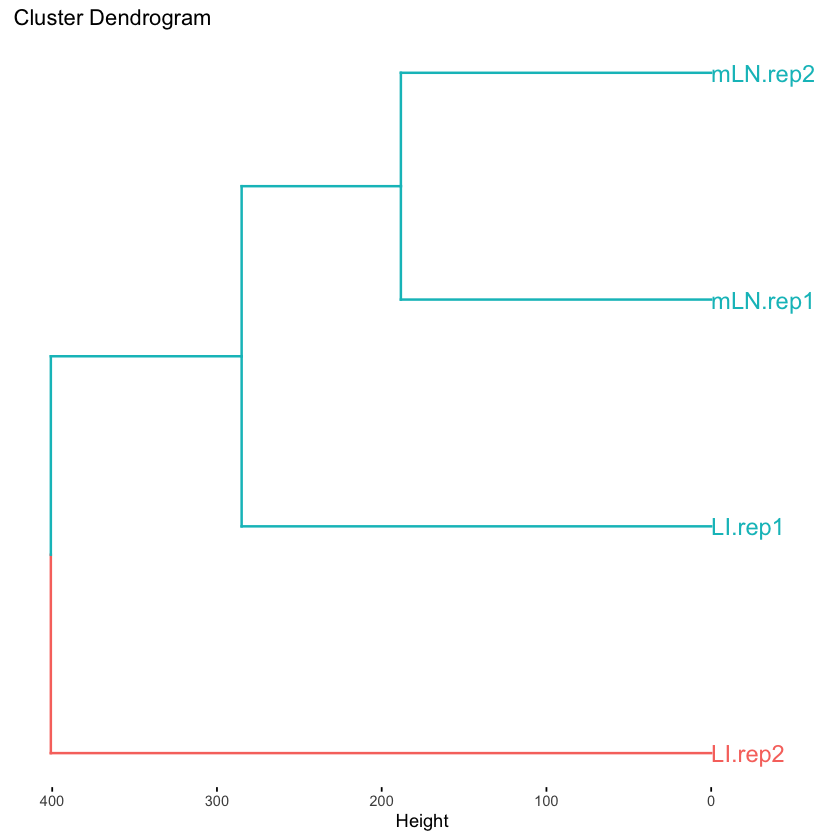

In [73]:
library('factoextra')          #下载并加载factoextra包
vsd <- vst(dds,blind = TRUE)    #参数blind=TRUE是为了不把样本分组信息考虑在内——即以无偏的方式进行转换
sampleDists <- dist(t(assay(vsd))) 
res1 <- hcut(sampleDists, k = 2, stand = FALSE,hc_method ="average" ) 
fviz_dend(res1,
          rect_fill = T,
          # 字体大小
          cex = 1,
          # 字体颜色
          color_labels_by_k=T,
          # 平行放置
          horiz=T)

### PCA主成分分析的方法

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



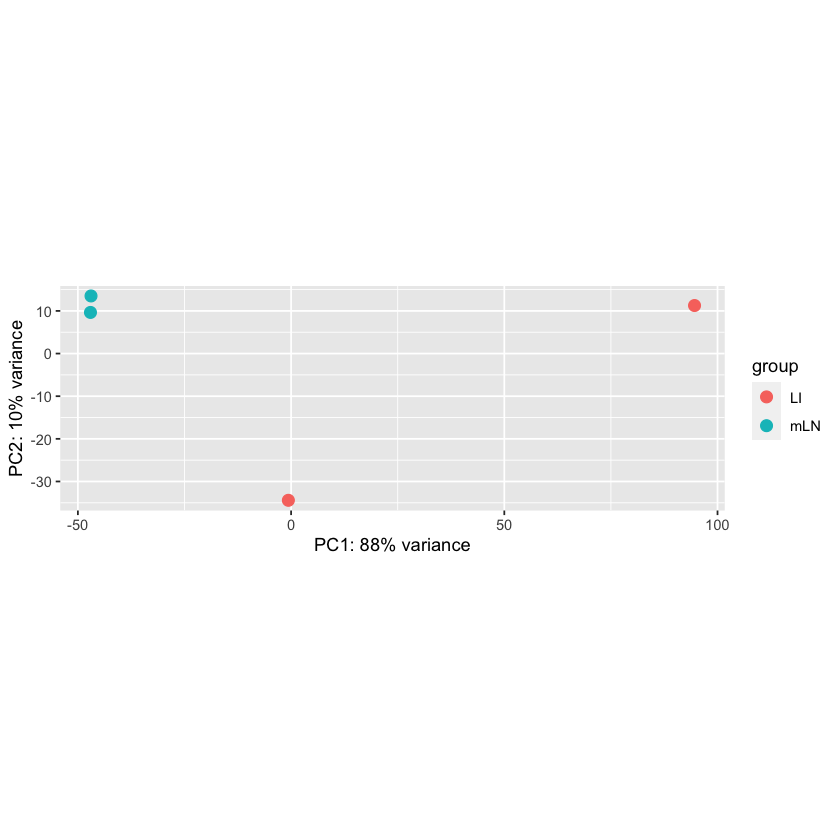

In [75]:
rld <- vst(dds, blind=FALSE)
#vst()函数效果和rlog（）一样，且速度更快。
plotPCA(rld, intgroup="condition",ntop=500)

9. 将dds输入DESeq函数#原始dds进行normalize
DESeq包含三步:
- estimation of size factors（estimateSizeFactors)
- estimation of dispersion（estimateDispersons)
- Negative Binomial GLM fitting and Wald statistics（nbinomWaldTest）
- 【可以分布运行，也可用一步到位，最后返回 results可用的DESeqDataSet对象。】

## 利用DESeq（）函数标准化dds矩阵

In [76]:
dds <- DESeq(dds)
dds

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 15617 4 
metadata(1): version
assays(4): counts mu H cooks
rownames(15617): Xkr4 Rp1 ... Zfp950 Csf2ra
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(4): LI.rep1 LI.rep2 mLN.rep1 mLN.rep2
colData names(4): sample condition type sizeFactor

In [82]:
resultsNames(dds)

[1] "Intercept"           "condition_mLN_vs_LI"

In [83]:
dds$condition        #默认后者的处理组比前面的对照组。

[1] LI  LI  mLN mLN
Levels: LI mLN

### Dispersion Plot
观察数据的离散情况

- A simple helper function that plots the per-gene dispersion estimates together with the fitted mean-dispersion relationship.

Arguments
- object
   - a DESeqDataSet, with dispersions estimated
- ymin
   - the lower bound for points on the plot, points beyond this are drawn as triangles at ymin
- genecol
   - the color for gene-wise dispersion estimates
- fitcol
   - the color of the fitted estimates
- finalcol
   - the color of the final estimates used for testing
- legend
   - logical, whether to draw a legend
- [文档](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/plotDispEsts)

In [77]:
pdf("../plots/000_Dispersion_plot.pdf",width=8,height=8)
plotDispEsts(dds, main="Dispersion plot")
dev.off()

pdf 
  2

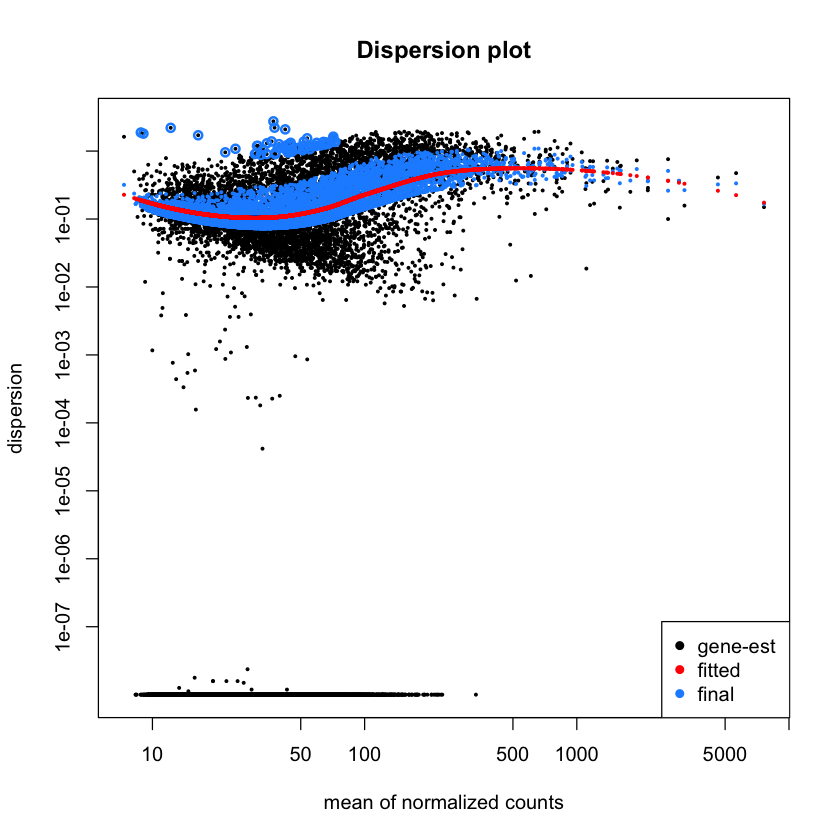

In [78]:
plotDispEsts(dds, main="Dispersion plot")

11. 将结果用results()函数来获取，赋值给res变量

In [79]:
vcmp

[1] "LI"  "mLN"

In [85]:
# 必要步骤！！！
res <- results(dds,contrast=c("condition", vcmp))
# summary一下，看一下结果的概要信息
#看一下结果的概要信息，p值默认小于0.1。
summary(res)


out of 15617 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1534, 9.8%
LFC < 0 (down)     : 9, 0.058%
outliers [1]       : 0, 0%
low counts [2]     : 4542, 29%
(mean count < 20)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## 提取差异分析结果

In [88]:
table(res$padj < 0.05)
#padj 即矫正后的P值。看看有多少差异基因满足所设的P值要求。
# TRUE的数值为满足要求的基因个数。



FALSE  TRUE 
10011  1064 

In [89]:
res <- res[order(res$padj),]
#按照padj 进行升序排列

In [91]:
resdata <- merge(
    as.data.frame(res), 
    as.data.frame(counts(dds, normalized=TRUE)),
    by="row.names",sort=FALSE)

resdata


Row.names,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,LI.rep1,LI.rep2,mLN.rep1,mLN.rep2
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bhlhe40,826.91827,6.585865,0.9999113,6.586449,4.504706e-11,4.988962e-07,954.65143,2319.1502,23.054284,10.817219
Pclaf,73.88743,3.510375,0.5887973,5.961942,2.492575e-09,1.380264e-05,142.22567,129.3233,10.479220,13.521524
Tmem151a,4622.96214,4.848402,0.8226995,5.893284,3.785946e-09,1.397645e-05,3607.82524,14263.8572,383.539452,236.626675
Junb,69.27043,3.816374,0.6572823,5.806293,6.387098e-09,1.768428e-05,102.32063,156.7774,12.575064,5.408610
Fosl2,301.73778,6.120207,1.0673093,5.734239,9.795094e-09,2.169613e-05,285.47454,904.5408,11.527142,5.408610
Spcs1,81.73403,4.059738,0.7155893,5.673279,1.400896e-08,2.585821e-05,101.29742,207.3508,11.527142,6.760762
Fam107b,485.40316,4.890570,0.8718043,5.609711,2.026649e-08,3.206448e-05,771.49751,1106.8343,33.533504,29.747353
Klf4,97.99973,4.669728,0.8402380,5.557625,2.734699e-08,3.365199e-05,104.36704,273.0962,10.479220,4.056457
Dusp1,137.26364,3.965963,0.7135635,5.557967,2.729349e-08,3.365199e-05,295.70661,220.3554,16.766752,16.225829


12. normalization前面的数据分布差异

In [92]:
### rld normalization ---------------------------------------------------------------------->
## 下面的代码如果你不感兴趣不需要运行，免得误导你
## 就是看看normalization前面的数据分布差异
rld <- rlogTransformation(dds)
raw_counts_new=assay(rld)
par(cex = 0.7)
n.sample=ncol(raw_counts)
if(n.sample>40) par(cex = 0.5)
cols <- rainbow(n.sample*1.2)
# 上一步比较耗时，算数据分布用

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



### Normalization:

In [93]:
pdf("../plots/001_expression_value_compare.pdf",width = 10, height = 6)
par(mfrow=c(1,2))
boxplot(raw_counts_select, col = cols,main="expression value_raw_counts: \nbefore normalization",las=2)
boxplot(raw_counts_new, col = cols,main="expression value_raw_counts_new: \nafter normalization",las=2)

dev.off()

pdf 
  2

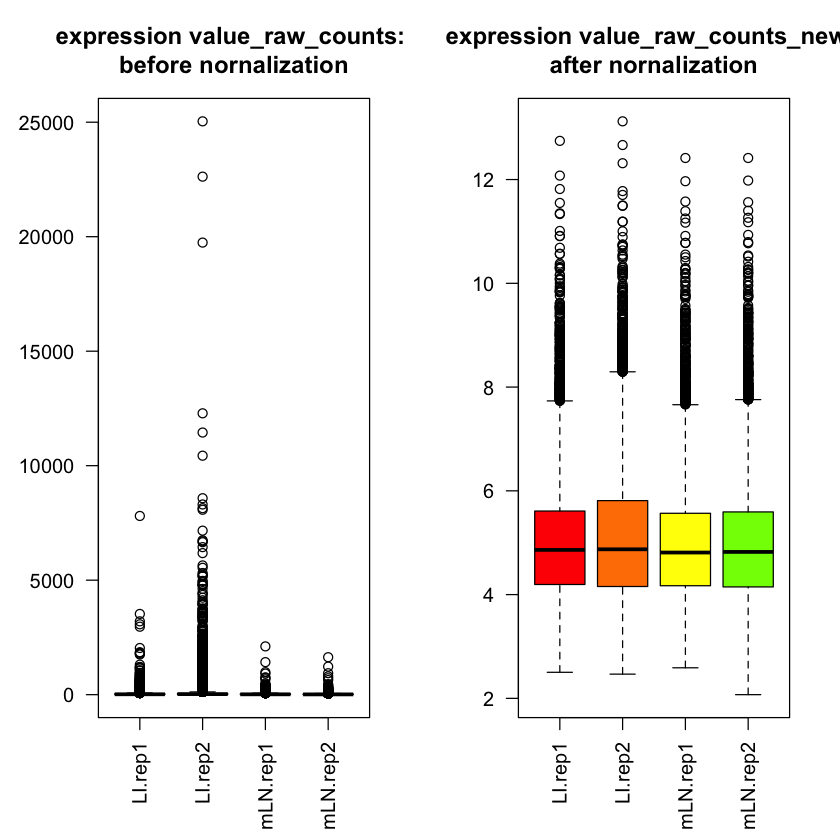

In [94]:
par(mfrow=c(1,2))
boxplot(raw_counts_select, col = cols,main="expression value_raw_counts: \nbefore nornalization",las=2)
boxplot(raw_counts_new, col = cols,main="expression value_raw_counts_new: \nafter nornalization",las=2)

In [96]:
pdf("../plots/002_expression_distribution_info_hist.pdf",width=8,height=8)
hist(raw_counts_new)
dev.off()

pdf 
  2

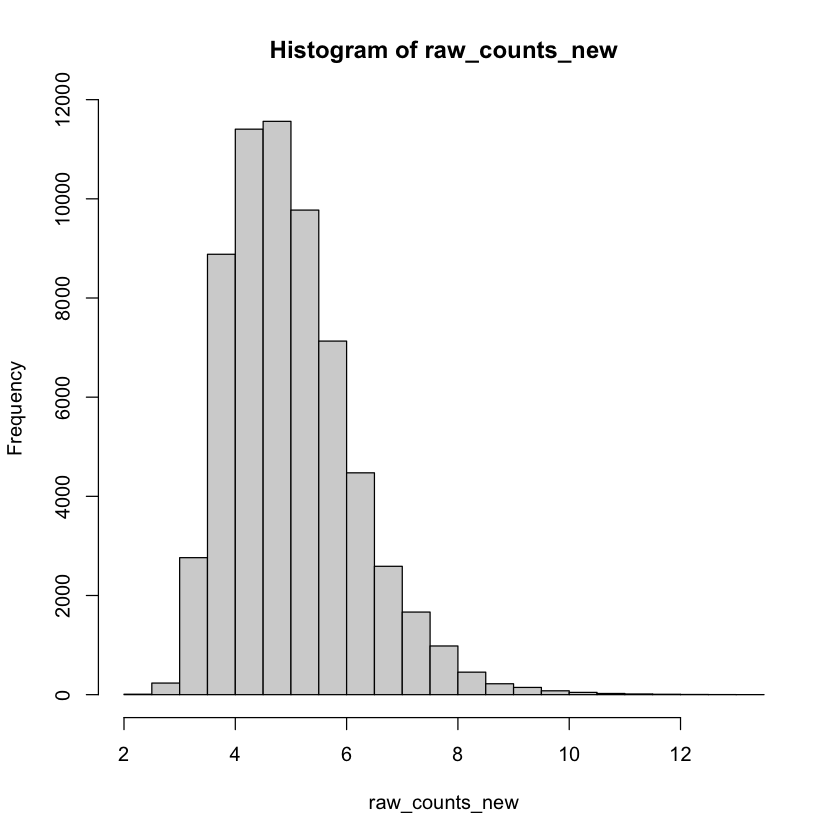

In [97]:
hist(raw_counts_new)

13. plot correlation heatmap

In [38]:
# 查看raw_counts_new
head(raw_counts_new)

,LI.rep1,LI.rep2,mLN.rep1,mLN.rep2
Xkr4,5.031664,4.882307,5.053077,5.399015
Rp1,6.641551,6.700952,6.914871,6.865408
Sox17,2.189672,2.337055,1.972270,1.936562
Mrpl15,5.326412,4.974663,5.769502,5.576632
Lypla1,5.290271,6.992104,4.437462,4.712895
Tcea1,5.181482,7.413852,5.266544,5.303059


In [ ]:
### plot correlation heatmap -------------------------------------------------------------->
library(RColorBrewer)
(mycols <- brewer.pal(8, "Dark2")[1:length(unique(column_info$condition))])
# Sample distance heatmap
sampleDists <- dist(t(raw_counts_new))
sampleDistsMatrix <- as.matrix(sampleDists)
head(sampleDistsMatrix)

In [ ]:
library(gplots)
library(pheatmap)

png("qc-heatmap-samples.png", w=1000, h=1000, pointsize=20)
# heatmap.2(sampleDistsMatrix, key=F, trace="none",
#         col=colorpanel(100, "black", "white"),
#          ColSideColors=mycols[column_info$condition], RowSideColors=mycols[column_info$condition],
#          margin=c(10, 10), main="Sample Distance Matrix")
colors <- colorRampPalette(rev(brewer.pal(9,"Blues")))(255)


ht <- pheatmap(sampleDistsMatrix,
               clustering_distance_cols = sampleDists,
               clustering_distance_rows = sampleDists,
               color = colors
              )
ht

In [ ]:
pdf("../plots/003_correlation_cross_samples_heatmap.pdf",width = 6, height = 6)
ht
dev.off()

14. MA plot
- log2 折叠变换和平均正常统计量的关系，红色的点表示在10%FDR的基因

In [ ]:
### MA plot ------------------------------------------------------------------------------>
pdf("../plots/004_DESeq2_MA_plot.pdf",width = 8, height = 8)
par(mfrow=c(1,1))
DESeq2::plotMA(res, main="DESeq2", ylim=c(-20,20))
dev.off()

15. nbinomTest的p值统计直方图

In [ ]:
pdf("../plots/005_nbinomTest_p_value.pdf",width = 8, height = 8)
hist(res$pvalue, breaks = 100, col = 'skyblue', border = 'slateblue', main = 'nbinomTest p value')
dev.off()

16. rld to PCA(vst is better than rlog when n>=30)

In [ ]:
pdf("../plots/006_PCAplot.pdf", width = 8, height = 8)
plotPCA(rld,intgroup=c("condition"))
dev.off()

17. 这个heatmap干嘛的？

In [ ]:
library(ggplot2)
d <- plotCounts(dds,gene=which.min(res$padj), intgroup = "condition",returnData = TRUE)

In [ ]:
pdf("../plots/007_jitter_plot_for_min_pvalue_transcript_counts.pdf", height = 8, width = 8)
ggplot(d,aes(x=condition,y=count))+
  geom_point(position = position_jitter(w=0.1,h=0))+
  scale_y_log10(breaks=c(25,100,400))
dev.off()

18. 处理res数据并且输出DEG表格

In [ ]:
### deal with res and extract DEG!!! ----------------------------------------------------->
# 标准cutoff
log2fc = 1  # >=1
pv = 0.05  # <=0.05
# 松cutoff
# log2fc = 1  # >=1
# pv = 1  # <=0.05


resOrdered <- res[order(res$padj),]
resOrdered[which(resOrdered$log2FoldChange >= log2fc & resOrdered$pvalue<pv), 'sig'] <- 'up'
resOrdered[which(resOrdered$log2FoldChange <= -log2fc & resOrdered$pvalue<pv),'sig'] <- 'down'
resOrdered[which(abs(resOrdered$log2FoldChange) <= log2fc & resOrdered$pvalue>=pv),'sig'] <- 'none'
resOrdered=as.data.frame(resOrdered)

write.table(resOrdered,"../plots/deseq2.all_sample.results.csv",col.names = NA, sep = ",", quote = FALSE)

deg <- subset(resOrdered, (abs(resOrdered$log2FoldChange) >=log2fc & resOrdered$padj<pv)) ##### extract DEG !

deg_matrix <- as.data.frame(deg)
write.table(deg_matrix, '../plots/deg_result.csv', col.names = NA, sep = ",", quote = FALSE)


# raw count norm by deseq2
write.table(raw_counts_new, '../plots/raw_counts_norm_by_DESeq2.csv', col.names = NA, sep = ",", quote = FALSE)

print(dim(deg))
deg

In [ ]:
### plot heatmap ------------------------------------------------------------------------->
### plot all genes heatmap
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:1000]  ### select first ordered 1000 genes(not deg)
#                 decreasing=TRUE)[1:50]  ### select first ordered 66 genes(not deg)
df <- as.data.frame(column_info(dds)[,c("condition")])
p1000 <- pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE,scale = "column")
p1000

In [ ]:
select <- order(rowMeans(counts(dds,normalized=TRUE)),
#                 decreasing=TRUE)[1:1000]  ### select first ordered 1000 genes(not deg)
                decreasing=TRUE)[1:50]  ### select first ordered 66 genes(not deg)
df <- as.data.frame(column_info(dds)[,c("condition")])
p50 <- pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE,scale = "column")
p50

In [ ]:
pdf("../plots/008_select_first_ordered_1000_transcriptsOrGenes_plot_heatmap.pdf",height = 20,width = 20)
p1000
dev.off()
pdf("../plots/009_select_first_ordered_50_transcriptsOrGenes_plot_heatmap.pdf",height = 20,width = 20)
p50
dev.off()

In [ ]:
### plot DEG heatmap
selected <- rownames(deg)
pDEG <- pheatmap(assay(rld)[rownames(rld) %in% selected,], 
#                  cluster_rows=TRUE, 
#                  show_rownames=TRUE,
                cluster_rows=TRUE, 
                show_rownames=FALSE,
         cluster_cols=FALSE, scale = "column")

In [ ]:
pdf("../plots/010_select_differential_expression_genes_heatmap.pdf",height = 5,width = 20)
pDEG
dev.off()

In [ ]:
resOrdered

In [ ]:
### plot valcano ------------------------------------------------------------------------>
vp <- ggplot(data = resOrdered, aes(x = log2FoldChange, y = -log10(padj),color = sig)) +
  geom_point(size = 1.7, alpha=0.8) +  #绘制散点图
  scale_color_manual(values = c('#B22222', 'gray', '#4169E1'), limits = c('up', 'none', 'down')) +  #自定义点的颜色
  labs(x = 'log2 Fold Change', y = '-log10 adjust p-value', title = 'control vs treat', color = '') +  #坐标轴标题
  theme(plot.title = element_text(hjust = 0.5, size = 14), panel.grid = element_blank(), #背景色、网格线、图例等主题修改
        panel.background = element_rect(color = 'black', fill = 'transparent'),
        legend.key = element_rect(fill = 'transparent')) +
  geom_vline(xintercept = c(-1, 1), lty = 3, color = 'black') +  #添加阈值线
  geom_hline(yintercept = 1.3, lty = 3, color = 'black') +
  # xlim(-2, 2) + ylim(0, 5)
  xlim(-10, 10) + ylim(0, 100)

vp

In [ ]:
pdf("../plots/011_select_differential_expression_genes_valcano_plot.pdf",height = 5,width = 8)
vp
dev.off()

# 转换所有基因名和差异表达基因名

In [ ]:
library(tidyverse)

In [ ]:
deg_res <- read_csv("../plots/deg_result.csv")
all_res <- read_csv("../plots/deseq2.all_sample.results.csv")
colnames(deg_res)

```
git clone https://github.com/xuzhougeng/org.At.tair.db.git
cd org.At.tair.db
Rscript org.At.tair.db.R
```

In [ ]:
library(AnnotationDbi)
library(org.Mm.eg.db)

In [ ]:
deg_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(deg_res$X1), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
deg_res_final <- deg_res %>% add_column(
    deg_anno,
    .after="X1"
)
head(deg_res_final)

In [ ]:
all_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(all_res$X1), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
all_res_final <- all_res %>% add_column(
    all_anno,
    .after="X1"
)
head(all_res_final)

In [ ]:
all_features <- read_tsv("all_feature_fix.csv")
head(all_features)

In [ ]:
head(all_features$Geneid)

In [ ]:
### remove version in ensembl id ----------------------------------------------------------->
gn <- stringr::str_split(all_features$Geneid,"\\.",simplify = T)[,1]
all_features$Geneid <- gn
head(all_features)

In [ ]:
all_features_anno <- AnnotationDbi::mapIds(
    org.Mm.eg.db, 
    keys=as.vector(all_features$Geneid), 
    column="SYMBOL", 
    keytype="ENSEMBL"
)
all_features_final <- all_features %>% add_column(
    all_features_anno,
    .after="Geneid"
)
head(all_features_final)

In [ ]:
write_tsv(deg_res_final,"deg_result_symbol.tsv")
write_tsv(all_res_final,"all_result_symbol.tsv")
write_tsv(all_features_final, "all_features_symbol.tsv")